# Galaxy Tool Sequence Prediction - Training 

In [1]:
import os, time, json, sys, logging
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Set project root
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("lstm_training")
logger.info(f"Project Root: {PROJECT_ROOT}")

2026-02-12 15:28:22,206 - INFO - Project Root: /home/henok/Desktop/Galaxy-GNN-XP-2


In [2]:
# 2. Load Processed Data
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_SAVE_DIR = PROJECT_ROOT / "Outputs"
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

logger.info("Loading datasets...")
X_train = torch.load(PROCESSED_DATA_DIR / "X_train.pt")
y_train = torch.load(PROCESSED_DATA_DIR / "y_train.pt")
X_test = torch.load(PROCESSED_DATA_DIR / "X_test.pt")
y_test = torch.load(PROCESSED_DATA_DIR / "y_test.pt")

with open(PROCESSED_DATA_DIR / "vocab.json", "r") as f:
    v_dict = json.load(f)
    stoi, itos = v_dict["stoi"], {int(k): v for k, v in v_dict["itos"].items()}

vocab_size, pad_idx = len(stoi), stoi.get("<PAD>", 0)
logger.info(f"Vocab Size: {vocab_size} | Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")

2026-02-12 15:29:45,858 - INFO - Loading datasets...
2026-02-12 15:29:46,211 - INFO - Vocab Size: 1318 | Training Samples: 5782 | Test Samples: 886


In [3]:
# 3. Model Architecture
class GalaxyPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1, :])
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyPredictor(vocab_size).to(device)
logger.info(f"Device: {device}")

2026-02-12 15:30:05,097 - INFO - Device: cpu


In [4]:
# 4. Training (Loss Tracking Only)
BATCH_SIZE, EPOCHS, LR = 64, 50, 1e-3
loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)

history = []
logger.info("Starting training loop...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for bx, by in loader:
        bx, by = bx.to(device), by.to(device)
        optimizer.zero_grad()
        loss = criterion(model(bx), by)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    history.append(avg_loss)
    logger.info(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {avg_loss:.4f}")

timestamp = time.strftime("%Y%m%d_%H%M%S")
save_path = MODEL_SAVE_DIR / f"galaxy_lstm_{timestamp}.pth"
torch.save(model.state_dict(), save_path)
logger.info(f"Model saved to {save_path.name}")

2026-02-12 15:30:43,278 - INFO - Starting training loop...
2026-02-12 15:31:05,744 - INFO - Epoch 01/50 | Train Loss: 6.0085
2026-02-12 15:31:20,541 - INFO - Epoch 02/50 | Train Loss: 5.1818
2026-02-12 15:31:34,197 - INFO - Epoch 03/50 | Train Loss: 4.6200
2026-02-12 15:31:49,324 - INFO - Epoch 04/50 | Train Loss: 4.1698
2026-02-12 15:32:03,178 - INFO - Epoch 05/50 | Train Loss: 3.8077
2026-02-12 15:32:17,322 - INFO - Epoch 06/50 | Train Loss: 3.4867
2026-02-12 15:32:33,444 - INFO - Epoch 07/50 | Train Loss: 3.2284
2026-02-12 15:32:47,934 - INFO - Epoch 08/50 | Train Loss: 3.0087
2026-02-12 15:33:00,532 - INFO - Epoch 09/50 | Train Loss: 2.8336
2026-02-12 15:33:13,398 - INFO - Epoch 10/50 | Train Loss: 2.6811
2026-02-12 15:33:27,421 - INFO - Epoch 11/50 | Train Loss: 2.5671
2026-02-12 15:33:40,007 - INFO - Epoch 12/50 | Train Loss: 2.4495
2026-02-12 15:33:53,069 - INFO - Epoch 13/50 | Train Loss: 2.3762
2026-02-12 15:34:06,038 - INFO - Epoch 14/50 | Train Loss: 2.3042
2026-02-12 15:34:

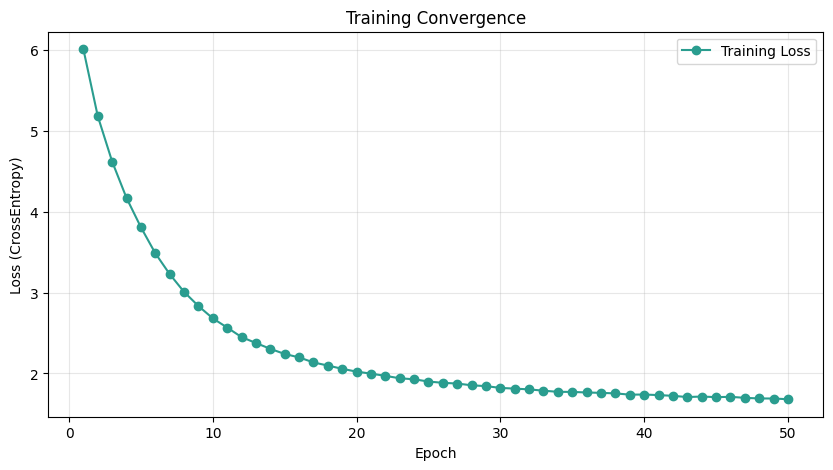

In [5]:
# 5. Training Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), history, marker='o', color='#2A9D8F', label='Training Loss')
plt.title('Training Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss (CrossEntropy)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [6]:
# 6. Actual vs Predicted Analysis (Test Set)
def show_comparison(n=10):
    model.eval()
    indices = np.random.choice(len(X_test), n, replace=False)
    print(f"\n{'='*50}")
    print(f"--- ACTUAL VS PREDICTED (Test Split Samples) ---")
    print(f"{'='*50}")
    
    with torch.no_grad():
        for idx in indices:
            inp = X_test[idx].unsqueeze(0).to(device)
            target_id = y_test[idx].item()
            
            logits = model(inp)
            pred_id = torch.argmax(logits, dim=1).item()
            
            actual = itos.get(target_id, "Unknown")
            predicted = itos.get(pred_id, "Unknown")
            context_last = itos.get(inp[0, -1].item(), "<PAD>")
            
            print(f"Context: ... -> {context_last}")
            print(f"  Actual:    {actual}")
            print(f"  Predicted: {predicted}")
            print("-" * 50)

show_comparison()


--- ACTUAL VS PREDICTED (Test Split Samples) ---
Context: ... -> Input dataset
  Actual:    Remove beginning
  Predicted: Input dataset
--------------------------------------------------
Context: ... -> Test if collection has only one item or is empty
  Actual:    Samtools merge
  Predicted: maskseq
--------------------------------------------------
Context: ... -> Input dataset
  Actual:    MaxQuant
  Predicted: Input dataset
--------------------------------------------------
Context: ... -> Remove beginning
  Actual:    Remove beginning
  Predicted: Collapse Collection
--------------------------------------------------
Context: ... -> DESeq2
  Actual:    Phyloseq Richness
  Predicted: Bandage Image
--------------------------------------------------
Context: ... -> Text reformatting
  Actual:    Text reformatting
  Predicted: Concatenate
--------------------------------------------------
Context: ... -> Samtools stats
  Actual:    Samtools view
  Predicted: MultiQC
------------------

In [7]:
# 7. Tool Recommendation Demo
def recommend(context, k=5, context_len=5):
    model.eval()
    unk = stoi.get("<UNK>", pad_idx)
    ids = [stoi.get(str(t), unk) for t in context][-context_len:]
    ids = [pad_idx]*(context_len - len(ids)) + ids
    inp = torch.tensor([ids], dtype=torch.long).to(device)
    with torch.no_grad():
        p = torch.softmax(model(inp), dim=1)
        vals, idxs = torch.topk(p, k=k)
    return [(itos[i.item()], v.item()) for v, i in zip(vals[0], idxs[0])]

print("\n--- INTERACTIVE RECOMMENDATION DEMO ---")
demo_ctx = ['<INPUT_DATA>', '<INPUT_DATA>', '<INPUT_DATA>', '<INPUT_DATA>', 'fastq_stats']
if 'fastq_stats' not in stoi:
    for i in range(3, 100):
        if itos[i] not in ['<PAD>', '<UNK>', '<INPUT_DATA>']:
            demo_ctx[-1] = itos[i]; break

print(f"Context: {demo_ctx}")
results = recommend(demo_ctx)
print("Predicted next tools:")
for tool, prob in results:
    print(f"  {tool}: {prob:.3f}")


--- INTERACTIVE RECOMMENDATION DEMO ---
Context: ['<INPUT_DATA>', '<INPUT_DATA>', '<INPUT_DATA>', '<INPUT_DATA>', 'Input dataset collection']
Predicted next tools:
  Input parameter: 0.466
  Input dataset: 0.264
  Input dataset collection: 0.060
  fastp: 0.019
  FastQC: 0.013
